# Determining optimal number of topics using Coherence Score

Determining the optimal number of topics (num_topics) in LDA topic modeling is crucial for extracting meaningful insights. We can use coherence score to find the best number of topics. The coherence score measures the quality of topics by evaluating the semantic similarity of the top words in each topic. The higher the coherence score, the better the topics.

Note:
In topic modeling using Latent Dirichlet Allocation (LDA), the coherence score is a metric used to evaluate how semantically similar the words within a topic are to each other, essentially measuring how interpretable and meaningful a given topic is to humans; a higher coherence score indicates that the words within a topic are closely related and make sense together, while a lower score suggests a less coherent, unclear topic. 

Num Topics: 2, Coherence Score: 0.4440
Num Topics: 4, Coherence Score: 0.4734
Num Topics: 6, Coherence Score: 0.5585
Num Topics: 8, Coherence Score: 0.5149
Num Topics: 10, Coherence Score: 0.5502
Num Topics: 12, Coherence Score: 0.5745
Num Topics: 14, Coherence Score: 0.5697


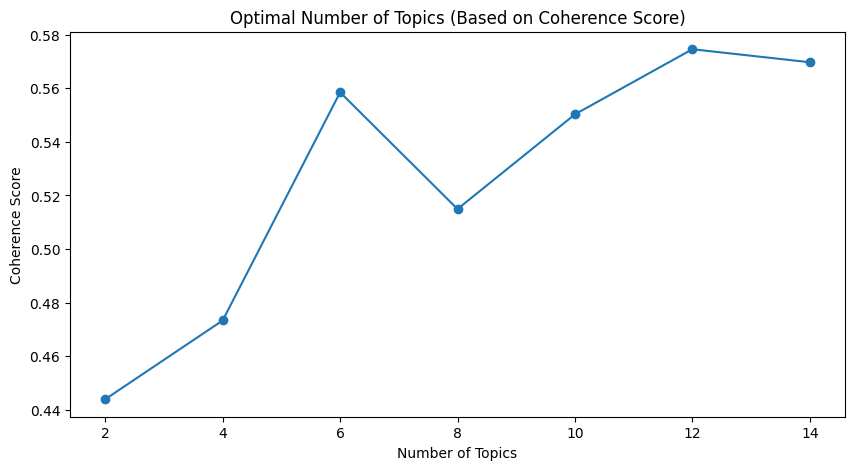

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Step 1: Load the dataset from the specified CSV file
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")  

# Step 2: Convert the 'content_words' column to lists of tokenized words, if stored as strings
df['content_words'] = df['content_words'].apply(eval)

# Step 3: Construct the dictionary and corpus required for topic modeling
dictionary = corpora.Dictionary(df['content_words'])
dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=10000)  # Terms appearing in too few or too many documents are filtered out
corpus = [dictionary.doc2bow(text) for text in df['content_words']]

# Step 4: Specify the range of topic numbers to be evaluated
topic_range = range(2, 15, 2)  # Even-numbered topics between 2 and 14
coherence_scores = []

# Step 5: Fit LDA models for each topic count and compute the corresponding coherence scores
for num_topics in topic_range:
    lda_model = gensim.models.LdaMulticore(
        corpus, num_topics=num_topics, id2word=dictionary, passes=5, workers=4, random_state=42
    )
    
    coherence_model = CoherenceModel(model=lda_model, texts=df['content_words'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# Step 6: Visualize the coherence scores across different numbers of topics
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics (Based on Coherence Score)")
plt.show()

# WordCloud and Bar Chart as the Visualization of the Topic Modelling Result

LDA Coherence Score: 0.5856
LDA Perplexity: -8.6330
Topic 0: 0.022*"state" + 0.021*"case" + 0.016*"law" + 0.015*"court" + 0.011*"federal" + 0.008*"charge" + 0.007*"trial" + 0.007*"legal" + 0.007*"prosecutor" + 0.006*"act"

Topic 1: 0.011*"service" + 0.010*"school" + 0.009*"health" + 0.008*"child" + 0.007*"program" + 0.007*"offer" + 0.006*"online" + 0.006*"information" + 0.006*"system" + 0.006*"student"

Topic 2: 0.016*"show" + 0.010*"video" + 0.010*"news" + 0.008*"game" + 0.007*"post" + 0.007*"book" + 0.007*"story" + 0.006*"play" + 0.006*"read" + 0.005*"social_medium"

Topic 3: 0.014*"city" + 0.009*"police" + 0.009*"home" + 0.006*"area" + 0.006*"hour" + 0.006*"four" + 0.006*"killed" + 0.006*"later" + 0.005*"last" + 0.005*"fire"

Topic 4: 0.031*"policy" + 0.026*"government" + 0.017*"change" + 0.016*"however" + 0.013*"plan" + 0.010*"per_cent" + 0.009*"report" + 0.009*"uk" + 0.008*"labour" + 0.007*"set"

Topic 5: 0.020*"million" + 0.015*"price" + 0.014*"high" + 0.012*"cost" + 0.011*"rate"

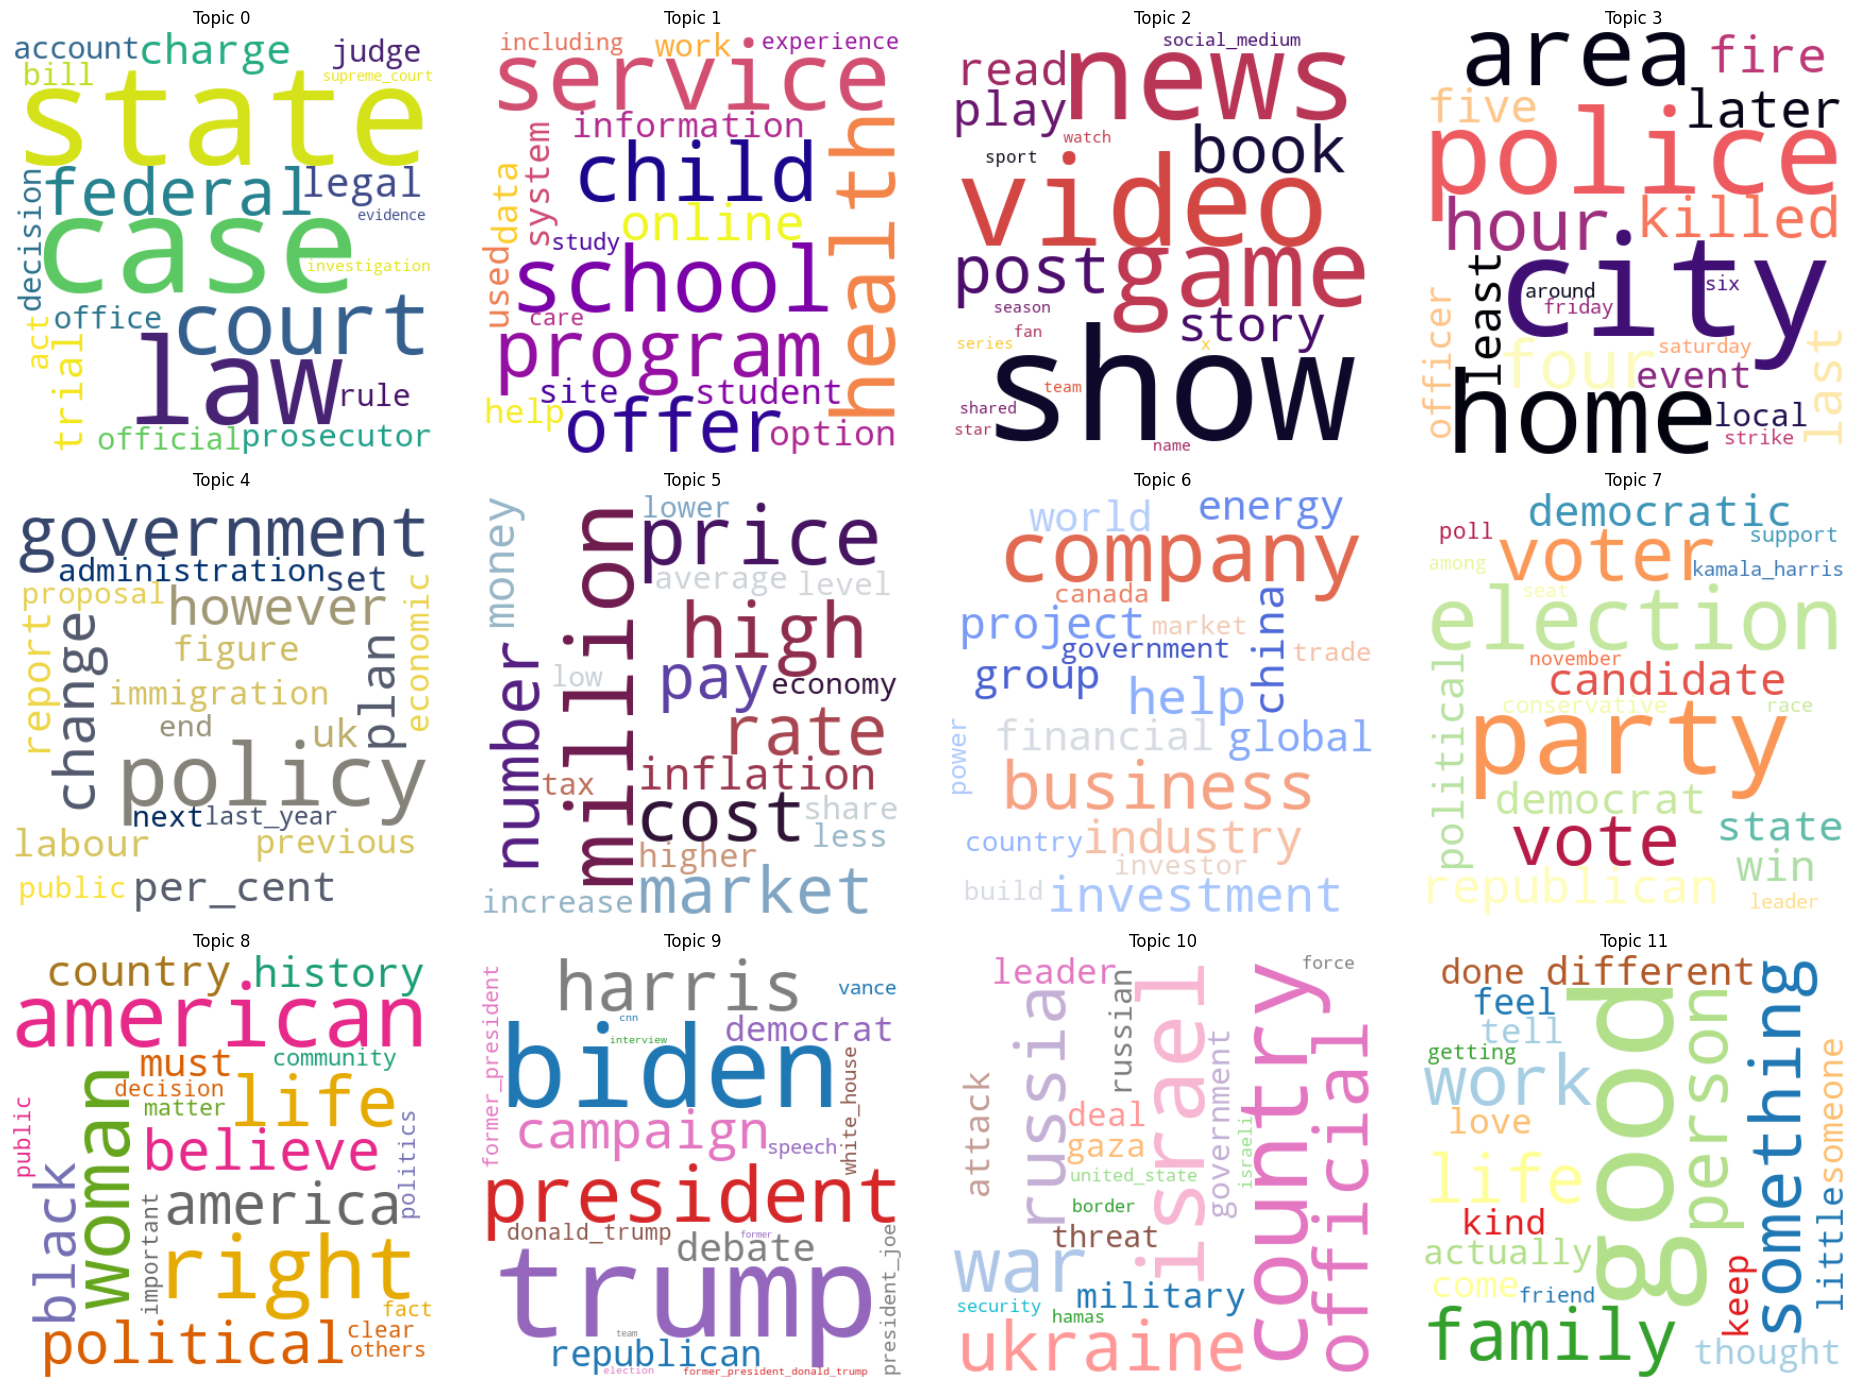

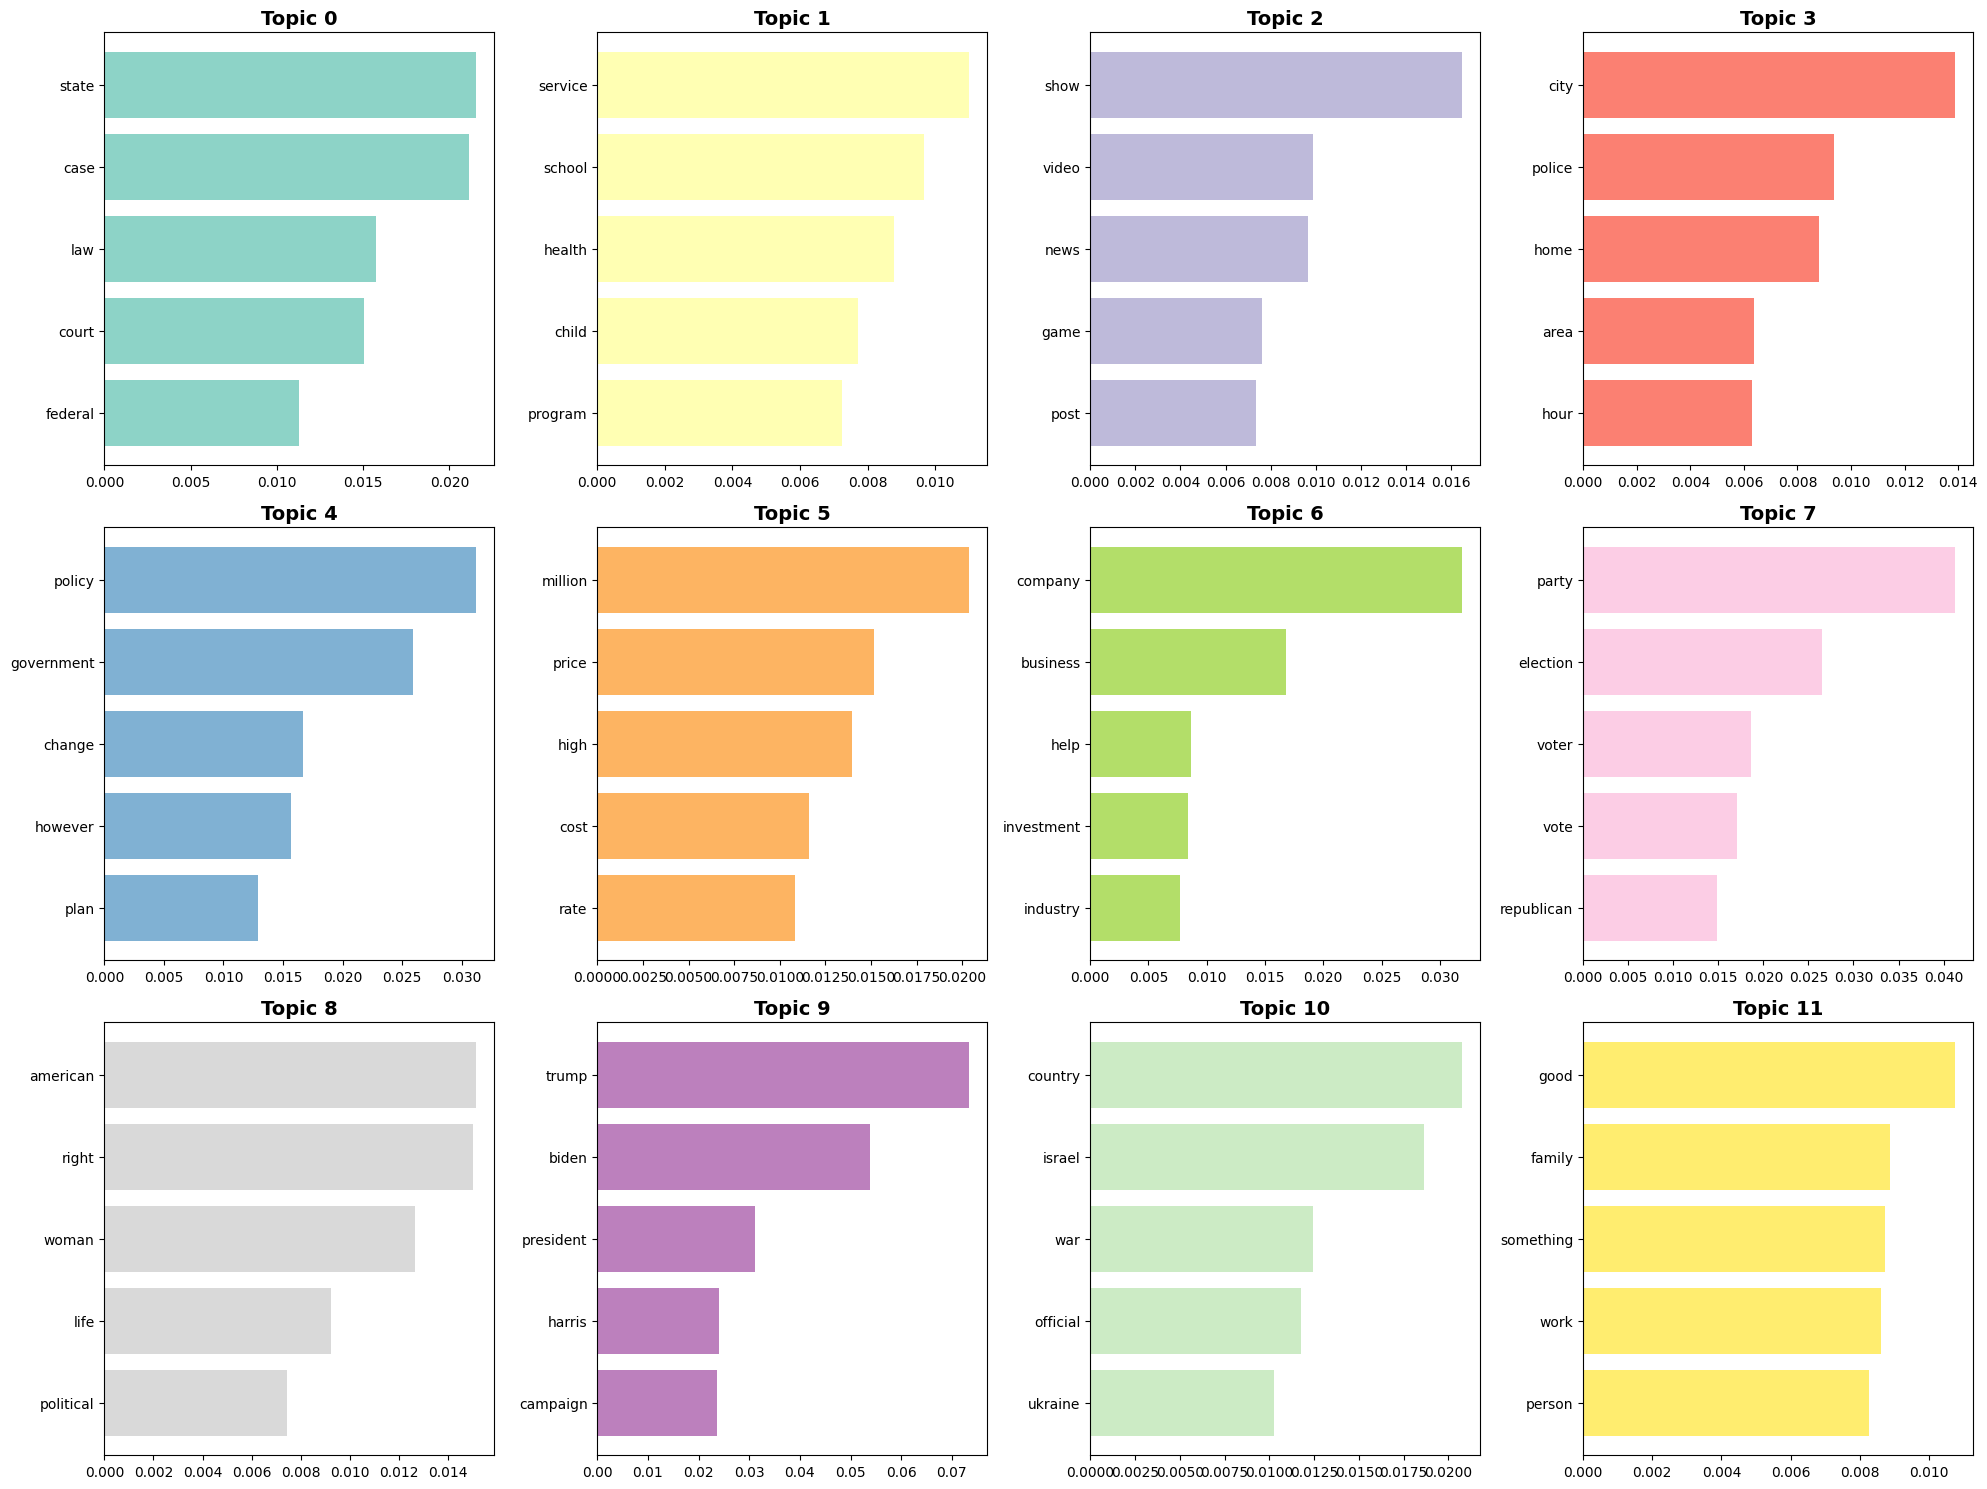

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

# Step 1: Load the dataset from the specified file path
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")  

# Step 2: Convert the 'content_words' column into a list of tokenized words, if stored as string
df['content_words'] = df['content_words'].apply(eval)

# Step 3: Identify common bigrams and trigrams using elevated threshold parameters to reduce noise
bigram = Phrases(df['content_words'], min_count=10, threshold=30)
trigram = Phrases(bigram[df['content_words']], min_count=10, threshold=30)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Step 4: Apply the detected bigrams and trigrams to the tokenized content
df['content_words'] = df['content_words'].apply(lambda x: trigram_mod[bigram_mod[x]])

# Step 5: Filter out additional low-information words using a customized stopword list
custom_stopwords = set([
    "could", "should", "would", "may", "might", "said", "year", "just", "many", "even", 
    "still", "back",  "day", "week", "month", "use", "give", "take", "since", "much", 
    "got", "whether", "look", "always", "let", "yet", "asked", "across"
])
df['content_words'] = df['content_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

# Step 6: Create and filter a dictionary for LDA input (using training data only)
dictionary = corpora.Dictionary(df['content_words'])  # initial creation before split (will be overwritten below)
dictionary.filter_extremes(no_below=20, no_above=0.3, keep_n=10000)

# Step 7: Split the data into training and testing sets for proper evaluation
train_texts, test_texts = train_test_split(df['content_words'], test_size=0.2)

# Step 8: Create a dictionary and corpus from the training data; prepare test corpus using same dictionary
dictionary = corpora.Dictionary(train_texts)
dictionary.filter_extremes(no_below=20, no_above=0.3, keep_n=10000)

train_corpus = [dictionary.doc2bow(text) for text in train_texts]
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

# Step 9: Train the LDA topic model using multicore processing on the training corpus
num_topics = 12
lda_model = LdaMulticore(
    corpus=train_corpus, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=10,
    workers=multiprocessing.cpu_count(), 
    random_state=42
)

# Step 10: Evaluate the model using coherence (semantic interpretability) and perplexity (generalization) on test set
coherence_model = CoherenceModel(model=lda_model, texts=test_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
perplexity_score = lda_model.log_perplexity(test_corpus)

# Display the computed evaluation metrics
print(f"LDA Coherence Score: {coherence_score:.4f}")
print(f"LDA Perplexity: {perplexity_score:.4f}")

# Step 11: Display the top representative words for each generated topic
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}\n")

# Step 12: Generate visual representations of each topic using word clouds with distinct colormaps
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 14))
axes = axes.flatten()
wordcloud_colors = ["viridis", "plasma", "inferno", "magma", "cividis", "twilight", "coolwarm", "Spectral", "Dark2", "tab10", "tab20", "Paired"]

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 20))
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap=wordcloud_colors[i]).generate_from_frequencies(topic_words)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Topic {i}")

plt.tight_layout()
plt.show()

# Step 13: Save the trained LDA model and dictionary to disk for future use
lda_model.save("lda_model.model")
dictionary.save("lda_dictionary.dict")

# Step 14: Visualize the top five words in each topic using horizontal bar charts with distinguishable colors
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()
distinct_colors = sns.color_palette("Set3", num_topics)

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 5))
    words = list(topic_words.keys())
    values = list(topic_words.values())
    
    axes[i].barh(words, values, color=distinct_colors[i])
    axes[i].invert_yaxis()
    axes[i].set_title(f"Topic {i}", fontsize=14, fontweight='bold')
    
plt.tight_layout()
plt.show()

# Assigning Dominant LDA Topic to Each Article
This section computes the dominant topic for each article by first running LDA on individual sentences, then aggregating the most frequent topic per article.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to compute topic distribution for each document using the trained LDA model
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        topic_vector = [prob for _, prob in topic_probs]
        topic_distributions.append(topic_vector)
    return np.array(topic_distributions)

# Step 1: Compute the topic distribution matrix for all documents (sentences)
topic_distributions = get_topic_distribution(lda_model, corpus)

# Step 2: Assign dominant topic per sentence
df["dominant_topic_lda"] = topic_distributions.argmax(axis=1)

# Step 3: Aggregate dominant topics per article (most frequent one)
article_topic = df.groupby("article_text")["dominant_topic_lda"].agg(lambda x: x.value_counts().idxmax()).reset_index()

# Step 4: Get article-level metadata (e.g., outlet, labels)
article_meta = df.drop_duplicates(subset="article_text")[["article_text", "outlet", "nlp_label", "nlp-image_label"]]

# Step 5: Merge metadata with dominant topic
df_articles = article_meta.merge(article_topic, on="article_text")

# Step 6: Define human-readable topic labels based on word clouds
topic_labels = {
    0: "Law & Legal System",
    1: "Public Services & Education",
    2: "Media & Entertainment",
    3: "Crime & Local News",
    4: "Politics & Government",
    5: "Economy & Inflation",
    6: "Business & Investment",
    7: "Elections & Political Parties",
    8: "Cultural Identity & Rights",
    9: "Presidential Campaigns",
    10: "War & Geopolitics",
    11: "Lifestyle & Personal Reflections"
}

# Step 7: Map topic number to human-readable topic name
df_articles["lda_topic_name"] = df_articles["dominant_topic_lda"].map(topic_labels)

# Step 8: Save the result
df_articles.to_csv("../datasets/articles_with_dominant_topic_lda.csv", index=False)

# Step 9: Preview the result
df_articles.head()

,article_text,outlet,nlp_label,nlp-image_label,dominant_topic_lda,lda_topic_name
0,Tij Iginla doesn't shy away from his famous la...,CBC.ca,Likely to be Bias,Likely to be Unbiased,2,Media & Entertainment
1,This week on The Sunday Magazine with host Piy...,CBC.ca,Likely to be Bias,Likely to be Unbiased,2,Media & Entertainment
2,An Ontario Conservative MP's use of ChatGPT to...,CBC News,Likely to be Bias,Likely to be Bias,1,Public Services & Education
3,"When it comes to the study of sports, a man's ...",CBC.ca,Likely to be Unbiased,Likely to be Unbiased,1,Public Services & Education
4,"To wrap up the 48th season of Quirks & Quarks,...",CBC.ca,Likely to be Bias,Likely to be Unbiased,11,Lifestyle & Personal Reflections


# Top 10 News Sources based on Topic Probability Distribution (Analyzing which outlets contribute most to topics)

This code analyzes how different news outlets cover various topics using a trained LDA model. It first extracts topic probabilities for each document and aggregates them by news source. The top 10 news sources are selected based on their total topic probability, ensuring that the most influential outlets are analyzed. The topic distributions are then normalized for fair comparison. The results are visualized using:

Stacked Bar Chart – Shows the proportion of topics across the top 10 news sources.
Heatmap – Highlights topic intensity for each news outlet, with a light-to-dark red gradient indicating lower to higher topic presence.
These visualizations help identify how different media sources emphasize various topics.

<Figure size 1400x800 with 0 Axes>

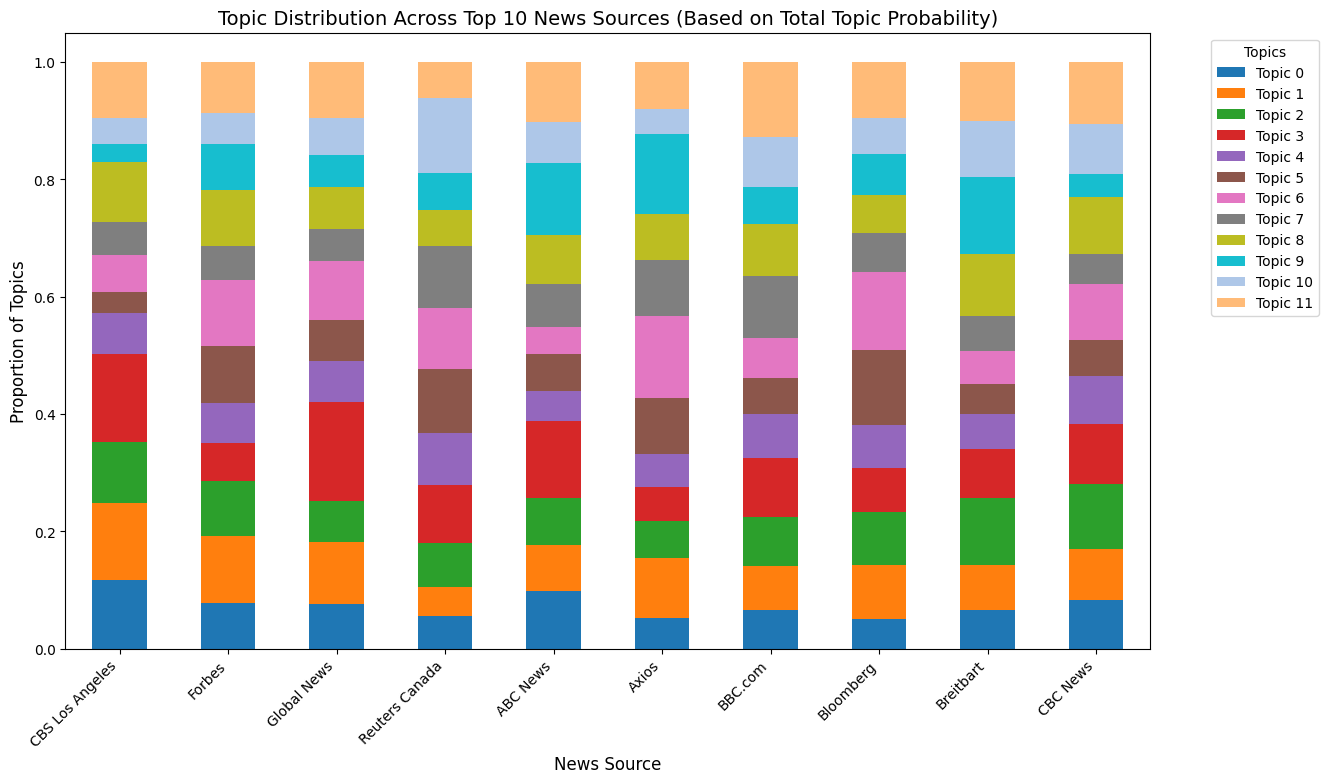

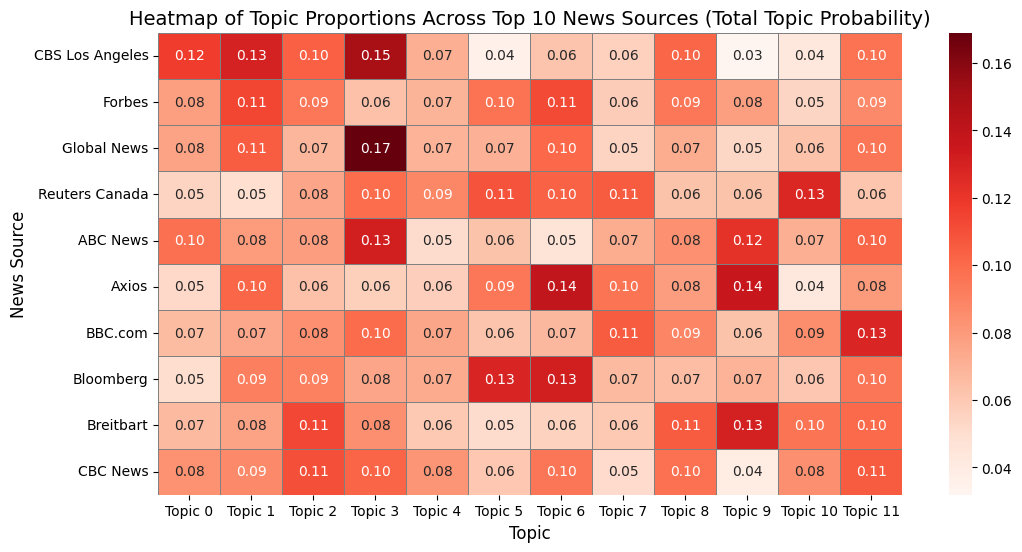

In [ ]:
# Step 1: Create topic distribution DataFrame for visualization
topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i}" for i in range(num_topics)])
topic_df["outlet"] = df["outlet"]

# Step 2: Compute average topic distribution per outlet
outlet_topic_distribution = topic_df.groupby("outlet").mean()

# Step 3: Focus on top 10 outlets
top_outlets = outlet_topic_distribution.sum(axis=1).nlargest(10).index
filtered_distribution = outlet_topic_distribution.loc[top_outlets]
filtered_distribution = filtered_distribution.div(filtered_distribution.sum(axis=1), axis=0)

# Visualization 1: Stacked Bar Chart
plt.figure(figsize=(14, 8))
color_palette = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78"
]
filtered_distribution.plot(kind="bar", stacked=True, figsize=(14, 8), color=color_palette)
plt.title("Topic Distribution Across Top 10 News Sources (Based on Total Topic Probability)", fontsize=14)
plt.xlabel("News Source", fontsize=12)
plt.ylabel("Proportion of Topics", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Visualization 2: Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_distribution, cmap="Reds", annot=True, fmt=".2f", linewidths=0.5, linecolor="gray")
plt.title("Heatmap of Topic Proportions Across Top 10 News Sources (Total Topic Probability)", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("News Source", fontsize=12)
plt.tight_layout()
plt.show()
